# App Behavior Analysis

* Source
    [Machine Learning - Get Your Hands Dirty by Solving Real Industry Challenges with Python](https://nlbsg.udemy.com/course/machine-learning-practical/learn/lecture/11839244#overview)

## Data
* Customer app behavior data
  * Includes
    * Date & time of App installation
    * App features that user engaged
  * Time Range
    * User's 1st day in the app (24 hour free trial)

## Process
* [Import Source Data](#import-source-data)
* [EDA](#eda)
    * [Data Cleaning](#data-cleaning)
    * [Feature Distributions](#feature-distributions)
    * [Feature Correlation With Label](#feature-Correlation-with-label)
    * [Feature Correlation Matrix](#feature-correlation-matrix)
* [Feature Engineering](#feature-engineering)
    * [Add feature](#add-feature)
        * [First Open - Enrolled Time](#first-open---enrolled-time)
            * [Add Feature (first open - enrolled time)](#add-feature-first-open---enrolled-time)
            * [Get New Feature Distribution](#get-new-feature-distribution)
            * [Zoom In Distribution](#zoom-in-distribution)
            * [Set Cut-off time](#set-cut-off-time)
* Data Pre-processing
* Model Building
* Model Conclusion

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from dateutil import parser

In [32]:
%matplotlib inline

## Import Source Data

In [85]:
app_data_df = pd.read_csv("dataset/P39-CS3-Data/appdata10.csv")
app_data_df.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


In [23]:
top_screens_df = pd.read_csv("dataset/P39-CS3-Data/top_screens.csv")
top_screens_df.head()

,Unnamed: 0,top_screens
0,0,Loan2
1,1,location
2,2,Institutions
3,3,Credit3Container
4,4,VerifyPhone


## EDA
* [Data Cleaning](#data-cleaning)
* [Feature Distributions](#feature-distributions)
* [Feature Correlation With Label](#feature-Correlation-with-label)
* [Feature Correlation Matrix](#feature-correlation-matrix)

In [24]:
app_data_df.describe()

,user,dayofweek,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
# Get type of each column
app_data_df.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                    object
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

### Data Cleaning
* Convert col types
* Drop the unwanted cols

In [26]:
app_data_df['hour'].head()

0     02:00:00
1     01:00:00
2     19:00:00
3     16:00:00
4     18:00:00
Name: hour, dtype: object

In [27]:
app_data_df['hour'].str.slice(1, 3).head()

0    02
1    01
2    19
3    16
4    18
Name: hour, dtype: object

In [28]:
# Convert col `hour` from `Object` to `Int`
app_data_df['hour'] = app_data_df['hour'].str.slice(1, 3).astype(int).head()

In [30]:
# Drop the unwanted columns
app_data_df2 = app_data_df.copy().drop(columns=['user', 'screen_list', 'enrolled_date', 'first_open', 'enrolled'])
app_data_df2.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked
0,3,2.0,23,15,0,0,0
1,6,1.0,24,13,0,0,0
2,1,19.0,23,3,0,1,1
3,4,16.0,28,40,0,0,0
4,1,18.0,31,32,0,0,1


### Feature Distributions

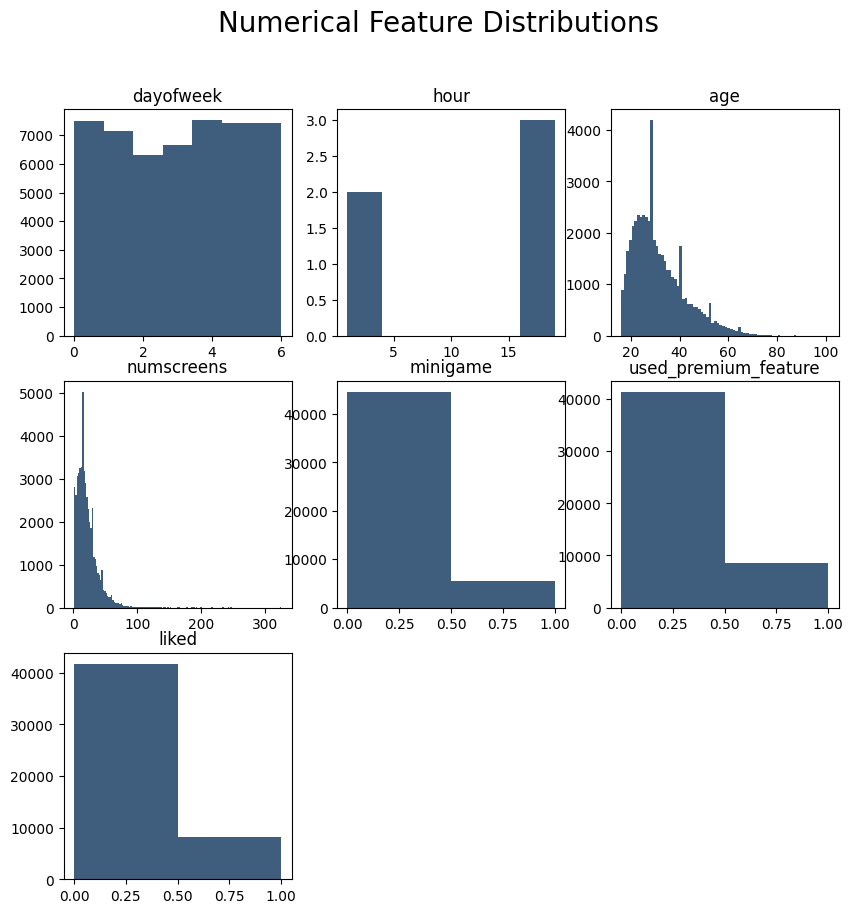

In [52]:
plt.figure(figsize=(10, 10))
plt.suptitle("Numerical Feature Distributions", fontsize=20)

for i in range(0, app_data_df2.shape[1]):
    plt.subplot(3, 3, i+1)
    f = plt.gca()
    f.set_title(app_data_df2.columns[i])

    unique_vals_size = np.size(app_data_df2.iloc[:, i].unique())
    plt.hist(app_data_df2.iloc[:, i], bins=unique_vals_size, color='#3F5D7D')

    


### Feature Correlation with Label
* Get feature correlation with label
* How each feature affect the label

<Axes: title={'center': 'Correlation with Label'}>

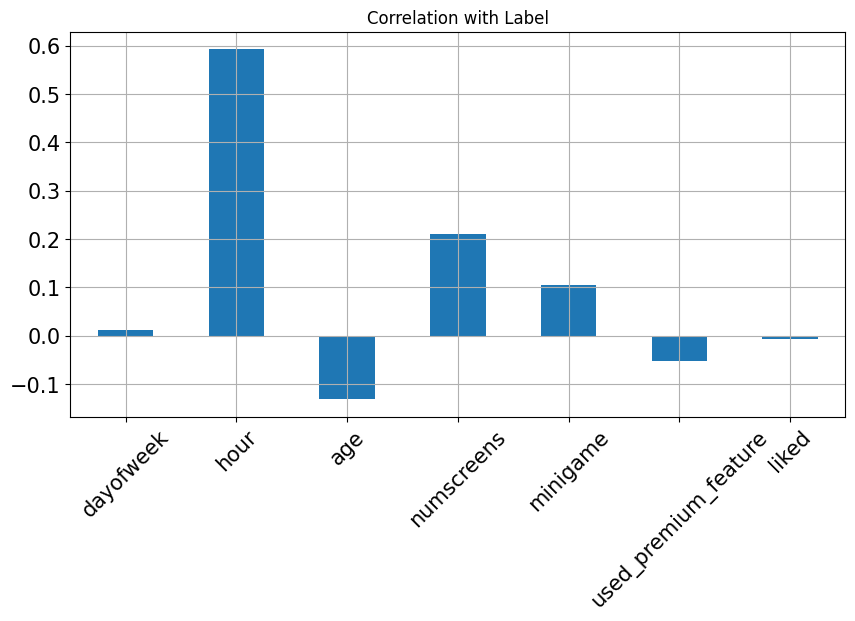

In [62]:
app_data_df2.corrwith(app_data_df.enrolled).plot.bar(figsize=(10, 5),
                                                     title="Correlation with Label",
                                                     fontsize=15,
                                                     rot=45,
                                                     grid=True)

### Feature Correlation Matrix
* Feature correlation with each other
* Use **heatmap**

<Axes: >

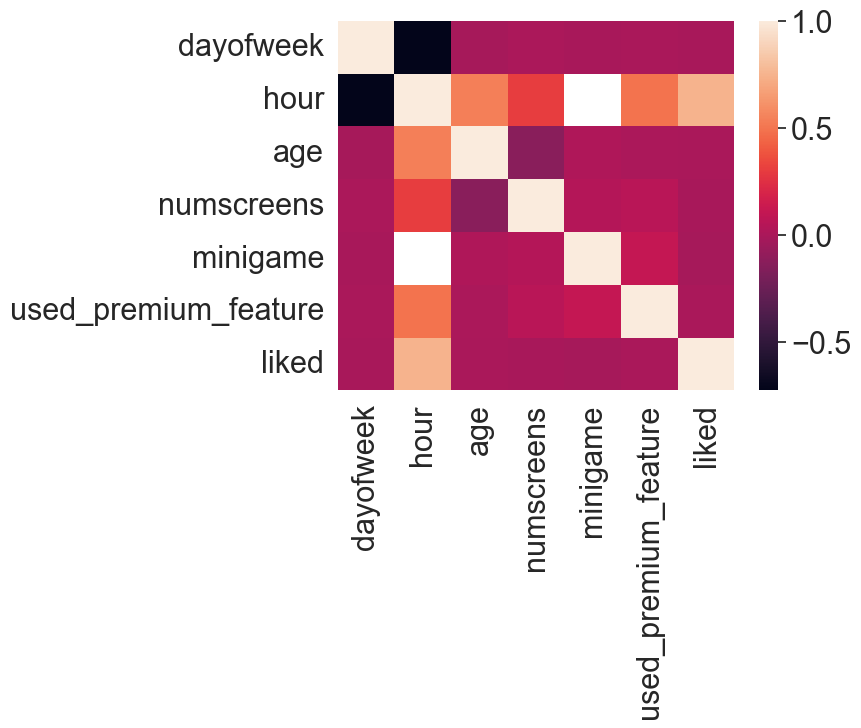

In [74]:
# Set figure background
sn.set(style="white", font_scale=2)

# Compute the correlation matrix
corr = app_data_df2.corr()

# Draw the heatmap
sn.heatmap(corr)

## Feature Engineering
* [Add feature (first open - enroll time)](#add-feature-first-open---enrolled-time)

In [79]:
# Get type of each column
app_data_df.dtypes

user                      int64
first_open               object
dayofweek                 int64
hour                    float64
age                       int64
screen_list              object
numscreens                int64
minigame                  int64
used_premium_feature      int64
enrolled                  int64
enrolled_date            object
liked                     int64
dtype: object

### First Open - Enrolled Time
* [Add Feature (first open - enrolled time)](#Add-feature-first-open---enrolled-time)
* [Get New Feature Distribution](#get-new-feature-distribution)
* [Zoom In Distribution](#zoom-in-distribution)
* [Set Cut-off time](#set-cut-off-time)

#### Add Feature (first open - enrolled time)

In [86]:
app_data_df["first_open"] = [parser.parse(row) for row in app_data_df["first_open"]]
app_data_df["enrolled_date"] = [parser.parse(row) if isinstance(row, str) else row for row in app_data_df["enrolled_date"]]

In [148]:
app_data_df["first_open_to_enroll"] = (app_data_df["enrolled_date"] - app_data_df["first_open"]).astype("timedelta64[s]")
app_data_df["first_open_to_enroll"].dtype

dtype('<m8[s]')

In [149]:
app_data_df["first_open_to_enroll"].dropna().head()

3    0 days 00:03:03
4    0 days 00:05:49
5    0 days 00:00:47
8   38 days 08:02:52
9    0 days 00:09:42
Name: first_open_to_enroll, dtype: timedelta64[s]

In [168]:
app_data_df["first_open_to_enroll_hour"] = (app_data_df["first_open_to_enroll"] / np.timedelta64(1, 'h')).astype(float)
app_data_df["first_open_to_enroll_hour"].dtype

dtype('float64')

#### Get New Feature Distribution

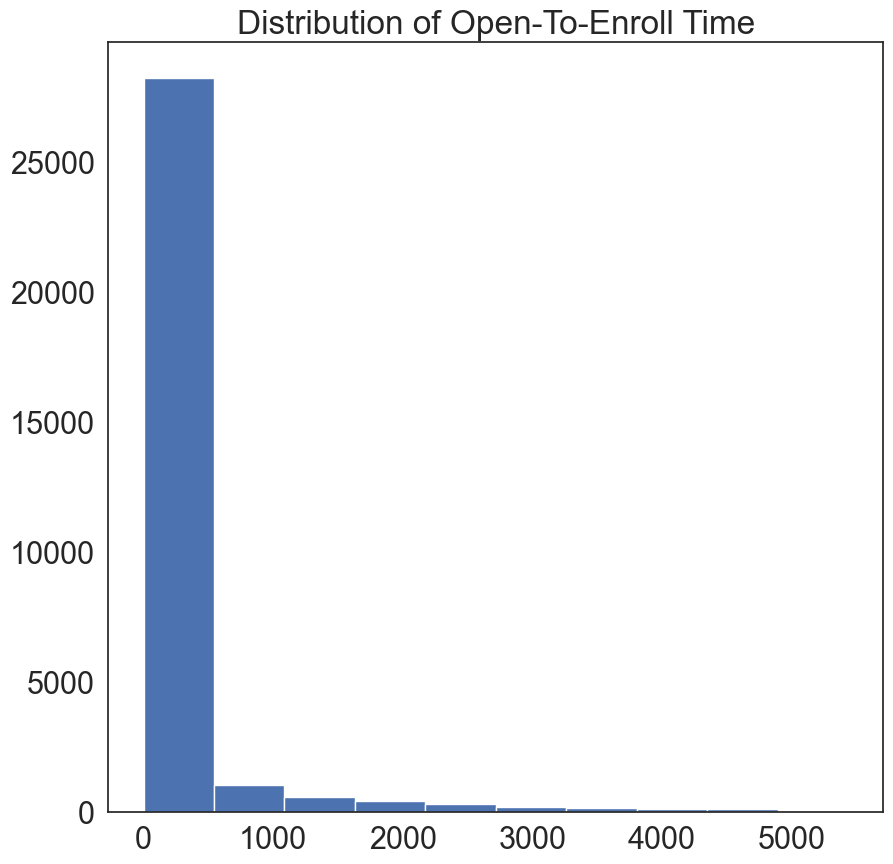

In [172]:
plt.figure(figsize=(10, 10))
plt.hist(app_data_df["first_open_to_enroll_hour"].dropna())
plt.title("Distribution of Open-To-Enroll Time")
plt.show()

#### Zoom In Distribution

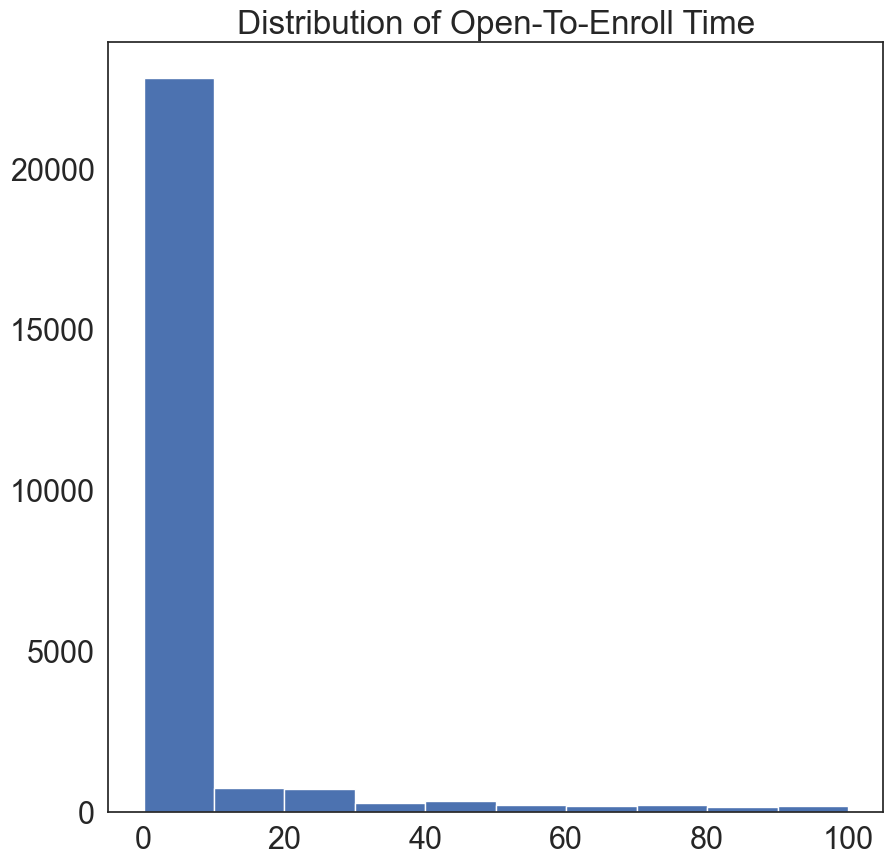

In [173]:
plt.figure(figsize=(10, 10))
plt.hist(app_data_df["first_open_to_enroll_hour"].dropna(), range=[0, 100])
plt.title("Distribution of Open-To-Enroll Time")
plt.show()

#### Set Cut-off time

Looks like we could cut-ff at 50 hours (set as 48 hrs)

We need a cut-off time to determine whether a user has enrolled or not

In [178]:
app_data_df.loc[app_data_df.first_open_to_enroll_hour > 48, "enrolled"] = 0

In [179]:
app_data_df = app_data_df.drop(columns=['first_open_to_enroll', 'enrolled_date', 'first_open'])